In [1]:
!git clone https://github.com/fanzeyi/pokemon.json.git --quiet > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import json
import requests
import os
import time
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from io import BytesIO
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.layers import LeakyReLU, Conv2D, Dropout, Flatten, Add, UpSampling2D
import imageio
from IPython.display import Image as IPyImage, display

In [8]:
# 共通設定
IMG_SIZE = 64
EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 16

In [5]:
# 1. データ取得

# ポケモン名リスト作成
with open("pokemon.json/pokedex.json", encoding="utf-8") as f:
    pokedex = json.load(f)

pokemon_names = []
for entry in pokedex:
    name = entry["name"]["english"]
    name_url = name.lower().replace(" ", "-").replace(".", "").replace("'", "").replace(":", "").replace("é", "e")
    pokemon_names.append(name_url)

print(f"Total Pokémon: {len(pokemon_names)}")
print(pokemon_names[:10])

Total Pokémon: 809
['bulbasaur', 'ivysaur', 'venusaur', 'charmander', 'charmeleon', 'charizard', 'squirtle', 'wartortle', 'blastoise', 'caterpie']


In [6]:
# ポケモン画像ダウンロード
save_dir = "pokemon_images_full"
os.makedirs(save_dir, exist_ok=True)
base_url = "https://img.pokemondb.net/artwork/large/{}.jpg"

for name in tqdm(pokemon_names, desc="Downloading Pokémon images"):
    url = base_url.format(name)
    response = requests.get(url)
    if response.status_code == 200:
        try:
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            img.save(os.path.join(save_dir, f"{name}.jpg"))
        except:
            continue
    time.sleep(0.5)

print("✅ All Pokémon images downloaded and resized.")

✅ All Pokémon images downloaded and resized.


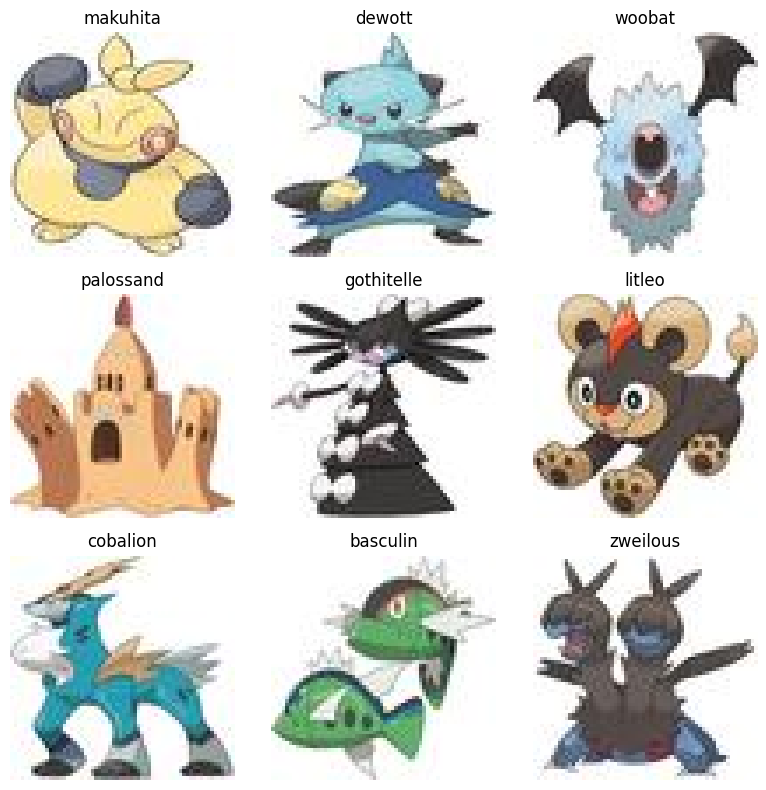

In [7]:
# ダウンロードした画像の確認
image_paths = glob.glob(os.path.join(save_dir, "*.jpg"))
sample_paths = random.sample(image_paths, min(9, len(image_paths)))

plt.figure(figsize=(8, 8))
for i, path in enumerate(sample_paths):
    img = Image.open(path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(path).replace(".jpg", ""))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
# 2. データ前処理 (train_dataset作成)

# 画像前処理
def preprocess_image(path):
    img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)
    img = (img - 127.5) / 127.5
    return img

image_paths = glob.glob(os.path.join("pokemon_images_full", "*.jpg"))
all_images = np.array([preprocess_image(p) for p in image_paths])

print(f"Loaded {all_images.shape[0]} images, shape: {all_images.shape[1:]}")

BUFFER_SIZE = all_images.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Loaded 802 images, shape: (64, 64, 3)


In [10]:
# 3. Generator/Discriminator定義

# Generator用ResBlock
class ResBlockUp(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ResBlockUp, self).__init__()
        self.upsample = UpSampling2D()
        self.conv1 = Conv2D(filters, (3,3), padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = LeakyReLU()
        self.conv2 = Conv2D(filters, (3,3), padding='same')
        self.bn2 = BatchNormalization()
        self.shortcut_conv = Conv2D(filters, (1,1), padding='same')
        self.shortcut_bn = BatchNormalization()
        self.relu_out = LeakyReLU()

    def call(self, x, training=True):
        shortcut = self.upsample(x)
        shortcut = self.shortcut_conv(shortcut)
        shortcut = self.shortcut_bn(shortcut, training=training)

        x = self.upsample(x)
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = Add()([x, shortcut])
        x = self.relu_out(x)
        return x

# Generator
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = Dense(8*8*256, use_bias=False)
        self.bn_fc = BatchNormalization()
        self.relu_fc = LeakyReLU()
        self.reshape = Reshape((8, 8, 256))
        self.resblock1 = ResBlockUp(128)
        self.resblock2 = ResBlockUp(64)
        self.resblock3 = ResBlockUp(32)
        self.conv_final = Conv2D(3, (3,3), padding='same', activation='tanh')

    def call(self, x, training=True):
        x = self.fc(x)
        x = self.bn_fc(x, training=training)
        x = self.relu_fc(x)
        x = self.reshape(x)
        x = self.resblock1(x, training=training)
        x = self.resblock2(x, training=training)
        x = self.resblock3(x, training=training)
        x = self.conv_final(x)
        return x

# Discriminator用ResBlock
class ResBlockDown(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ResBlockDown, self).__init__()
        self.conv1 = Conv2D(filters, (3,3), strides=2, padding='same')
        self.relu1 = LeakyReLU()
        self.conv2 = Conv2D(filters, (3,3), padding='same')
        self.relu2 = LeakyReLU()
        self.shortcut_conv = Conv2D(filters, (1,1), strides=2, padding='same')

    def call(self, x, training=True):
        shortcut = self.shortcut_conv(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = Add()([x, shortcut])
        x = self.relu2(x)
        return x

# Discriminator
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.resblock1 = ResBlockDown(64)
        self.resblock2 = ResBlockDown(128)
        self.resblock3 = ResBlockDown(256)
        self.flatten = Flatten()
        self.fc = Dense(1)

    def call(self, x, training=True):
        x = self.resblock1(x, training=training)
        x = self.resblock2(x, training=training)
        x = self.resblock3(x, training=training)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [11]:
# 4. Loss/Optimizer/Train関数

# Loss関数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Model & Optimizer
generator = Generator()
discriminator = Discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

In [12]:
# 5. generate_and_save_images / train_step / train()

# 固定seed → 進捗比較用
fixed_seed = tf.random.normal([num_examples_to_generate, noise_dim])

# 画像保存＋Notebook表示
def generate_and_save_images(model, epoch, seed):
    predictions = model(seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        img = (predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig(f'pokemon_image_at_epoch_{epoch:04d}.png')
    plt.show()
    plt.close()

# train_step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# train関数 (10エポック毎＋最終のみ保存)
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            generate_and_save_images(generator, epoch + 1, fixed_seed)
            print(f'✅ Image saved at epoch {epoch+1}')

        print(f'Epoch {epoch+1}/{epochs} done ✅')

Epoch 1/2000 done ✅
Epoch 2/2000 done ✅
Epoch 3/2000 done ✅
Epoch 4/2000 done ✅
Epoch 5/2000 done ✅
Epoch 6/2000 done ✅
Epoch 7/2000 done ✅
Epoch 8/2000 done ✅
Epoch 9/2000 done ✅


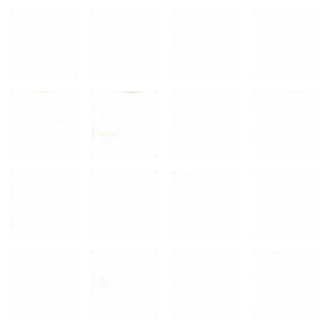

✅ Image saved at epoch 10
Epoch 10/2000 done ✅
Epoch 11/2000 done ✅
Epoch 12/2000 done ✅
Epoch 13/2000 done ✅
Epoch 14/2000 done ✅
Epoch 15/2000 done ✅
Epoch 16/2000 done ✅
Epoch 17/2000 done ✅
Epoch 18/2000 done ✅
Epoch 19/2000 done ✅


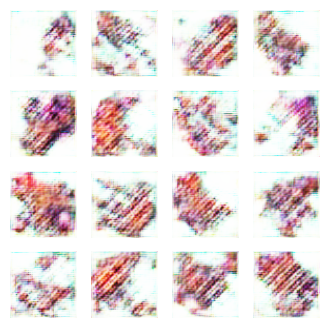

✅ Image saved at epoch 20
Epoch 20/2000 done ✅
Epoch 21/2000 done ✅
Epoch 22/2000 done ✅
Epoch 23/2000 done ✅
Epoch 24/2000 done ✅
Epoch 25/2000 done ✅
Epoch 26/2000 done ✅
Epoch 27/2000 done ✅
Epoch 28/2000 done ✅
Epoch 29/2000 done ✅


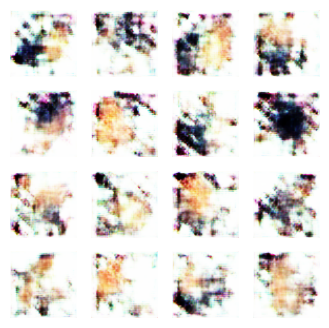

✅ Image saved at epoch 30
Epoch 30/2000 done ✅
Epoch 31/2000 done ✅
Epoch 32/2000 done ✅
Epoch 33/2000 done ✅
Epoch 34/2000 done ✅
Epoch 35/2000 done ✅
Epoch 36/2000 done ✅
Epoch 37/2000 done ✅
Epoch 38/2000 done ✅
Epoch 39/2000 done ✅


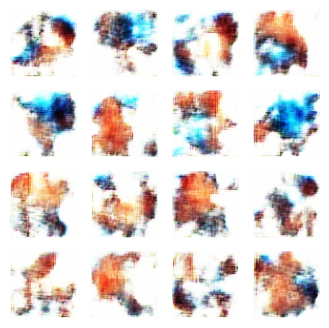

✅ Image saved at epoch 40
Epoch 40/2000 done ✅
Epoch 41/2000 done ✅
Epoch 42/2000 done ✅
Epoch 43/2000 done ✅
Epoch 44/2000 done ✅
Epoch 45/2000 done ✅
Epoch 46/2000 done ✅
Epoch 47/2000 done ✅
Epoch 48/2000 done ✅
Epoch 49/2000 done ✅


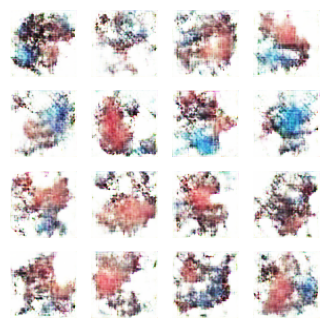

✅ Image saved at epoch 50
Epoch 50/2000 done ✅
Epoch 51/2000 done ✅
Epoch 52/2000 done ✅
Epoch 53/2000 done ✅
Epoch 54/2000 done ✅
Epoch 55/2000 done ✅
Epoch 56/2000 done ✅
Epoch 57/2000 done ✅
Epoch 58/2000 done ✅
Epoch 59/2000 done ✅


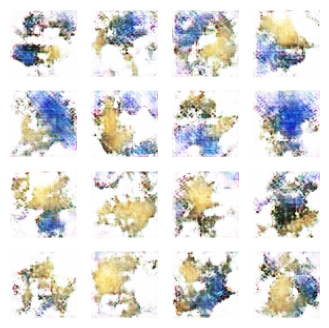

✅ Image saved at epoch 60
Epoch 60/2000 done ✅
Epoch 61/2000 done ✅
Epoch 62/2000 done ✅
Epoch 63/2000 done ✅
Epoch 64/2000 done ✅
Epoch 65/2000 done ✅
Epoch 66/2000 done ✅
Epoch 67/2000 done ✅
Epoch 68/2000 done ✅
Epoch 69/2000 done ✅


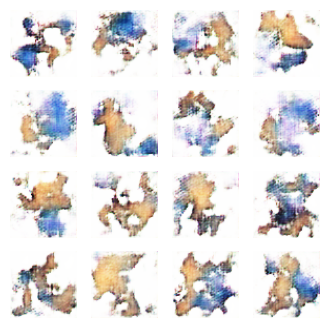

✅ Image saved at epoch 70
Epoch 70/2000 done ✅
Epoch 71/2000 done ✅
Epoch 72/2000 done ✅
Epoch 73/2000 done ✅
Epoch 74/2000 done ✅
Epoch 75/2000 done ✅
Epoch 76/2000 done ✅
Epoch 77/2000 done ✅
Epoch 78/2000 done ✅
Epoch 79/2000 done ✅


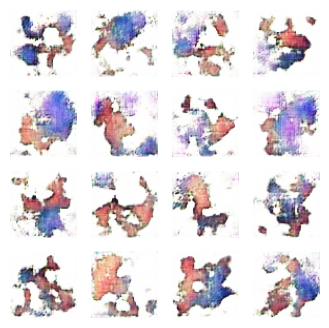

✅ Image saved at epoch 80
Epoch 80/2000 done ✅
Epoch 81/2000 done ✅
Epoch 82/2000 done ✅
Epoch 83/2000 done ✅
Epoch 84/2000 done ✅
Epoch 85/2000 done ✅
Epoch 86/2000 done ✅
Epoch 87/2000 done ✅
Epoch 88/2000 done ✅
Epoch 89/2000 done ✅


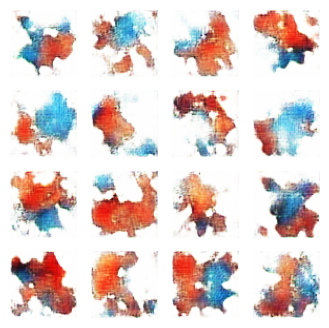

✅ Image saved at epoch 90
Epoch 90/2000 done ✅
Epoch 91/2000 done ✅
Epoch 92/2000 done ✅
Epoch 93/2000 done ✅
Epoch 94/2000 done ✅
Epoch 95/2000 done ✅
Epoch 96/2000 done ✅
Epoch 97/2000 done ✅
Epoch 98/2000 done ✅
Epoch 99/2000 done ✅


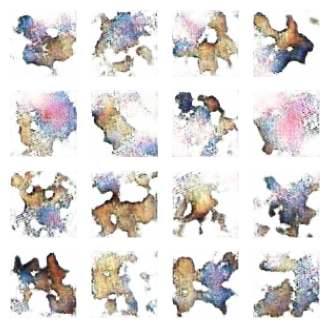

✅ Image saved at epoch 100
Epoch 100/2000 done ✅
Epoch 101/2000 done ✅
Epoch 102/2000 done ✅
Epoch 103/2000 done ✅
Epoch 104/2000 done ✅
Epoch 105/2000 done ✅
Epoch 106/2000 done ✅
Epoch 107/2000 done ✅
Epoch 108/2000 done ✅
Epoch 109/2000 done ✅


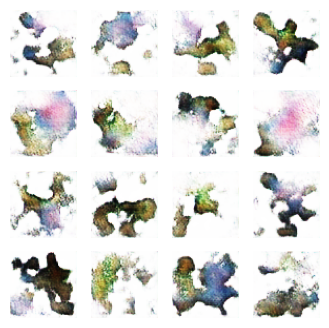

✅ Image saved at epoch 110
Epoch 110/2000 done ✅
Epoch 111/2000 done ✅
Epoch 112/2000 done ✅
Epoch 113/2000 done ✅
Epoch 114/2000 done ✅
Epoch 115/2000 done ✅
Epoch 116/2000 done ✅
Epoch 117/2000 done ✅
Epoch 118/2000 done ✅
Epoch 119/2000 done ✅


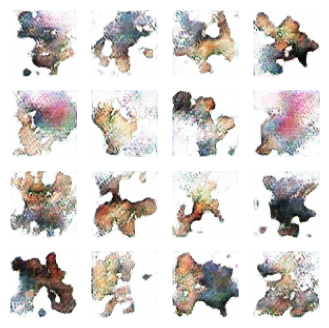

✅ Image saved at epoch 120
Epoch 120/2000 done ✅
Epoch 121/2000 done ✅
Epoch 122/2000 done ✅
Epoch 123/2000 done ✅
Epoch 124/2000 done ✅
Epoch 125/2000 done ✅
Epoch 126/2000 done ✅
Epoch 127/2000 done ✅
Epoch 128/2000 done ✅
Epoch 129/2000 done ✅


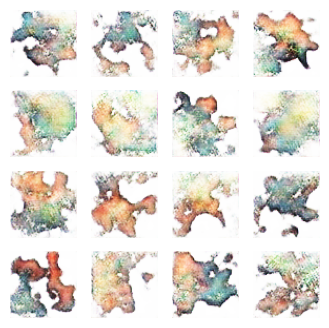

✅ Image saved at epoch 130
Epoch 130/2000 done ✅
Epoch 131/2000 done ✅
Epoch 132/2000 done ✅
Epoch 133/2000 done ✅
Epoch 134/2000 done ✅
Epoch 135/2000 done ✅
Epoch 136/2000 done ✅
Epoch 137/2000 done ✅
Epoch 138/2000 done ✅
Epoch 139/2000 done ✅


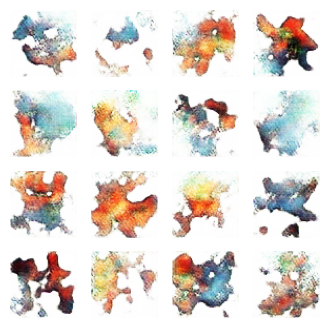

✅ Image saved at epoch 140
Epoch 140/2000 done ✅
Epoch 141/2000 done ✅
Epoch 142/2000 done ✅
Epoch 143/2000 done ✅
Epoch 144/2000 done ✅
Epoch 145/2000 done ✅
Epoch 146/2000 done ✅
Epoch 147/2000 done ✅
Epoch 148/2000 done ✅
Epoch 149/2000 done ✅


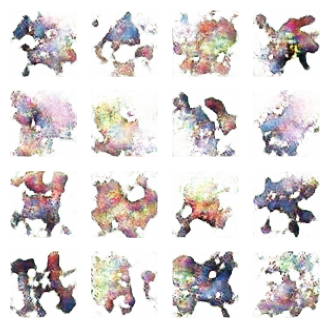

✅ Image saved at epoch 150
Epoch 150/2000 done ✅
Epoch 151/2000 done ✅
Epoch 152/2000 done ✅
Epoch 153/2000 done ✅
Epoch 154/2000 done ✅
Epoch 155/2000 done ✅
Epoch 156/2000 done ✅
Epoch 157/2000 done ✅
Epoch 158/2000 done ✅
Epoch 159/2000 done ✅


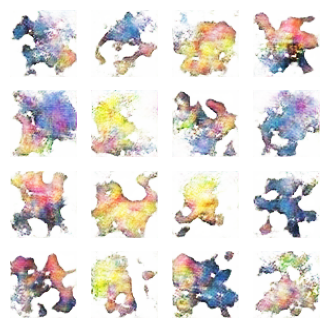

✅ Image saved at epoch 160
Epoch 160/2000 done ✅
Epoch 161/2000 done ✅
Epoch 162/2000 done ✅
Epoch 163/2000 done ✅
Epoch 164/2000 done ✅
Epoch 165/2000 done ✅
Epoch 166/2000 done ✅
Epoch 167/2000 done ✅
Epoch 168/2000 done ✅
Epoch 169/2000 done ✅


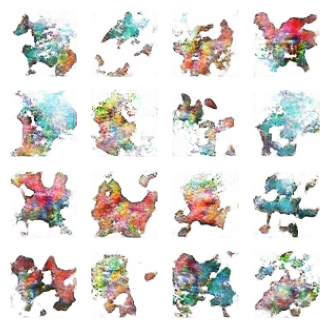

✅ Image saved at epoch 170
Epoch 170/2000 done ✅
Epoch 171/2000 done ✅
Epoch 172/2000 done ✅
Epoch 173/2000 done ✅
Epoch 174/2000 done ✅
Epoch 175/2000 done ✅
Epoch 176/2000 done ✅
Epoch 177/2000 done ✅
Epoch 178/2000 done ✅
Epoch 179/2000 done ✅


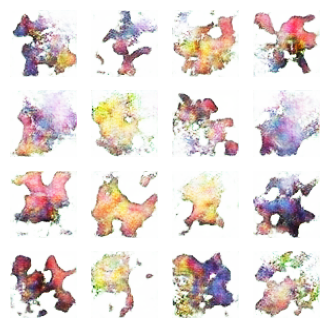

✅ Image saved at epoch 180
Epoch 180/2000 done ✅
Epoch 181/2000 done ✅
Epoch 182/2000 done ✅
Epoch 183/2000 done ✅
Epoch 184/2000 done ✅
Epoch 185/2000 done ✅
Epoch 186/2000 done ✅
Epoch 187/2000 done ✅
Epoch 188/2000 done ✅
Epoch 189/2000 done ✅


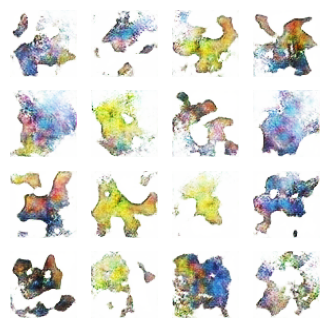

✅ Image saved at epoch 190
Epoch 190/2000 done ✅
Epoch 191/2000 done ✅
Epoch 192/2000 done ✅
Epoch 193/2000 done ✅
Epoch 194/2000 done ✅
Epoch 195/2000 done ✅
Epoch 196/2000 done ✅
Epoch 197/2000 done ✅
Epoch 198/2000 done ✅
Epoch 199/2000 done ✅


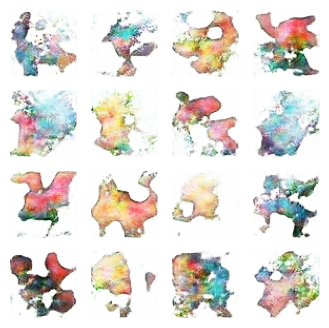

✅ Image saved at epoch 200
Epoch 200/2000 done ✅
Epoch 201/2000 done ✅
Epoch 202/2000 done ✅
Epoch 203/2000 done ✅
Epoch 204/2000 done ✅
Epoch 205/2000 done ✅
Epoch 206/2000 done ✅
Epoch 207/2000 done ✅
Epoch 208/2000 done ✅
Epoch 209/2000 done ✅


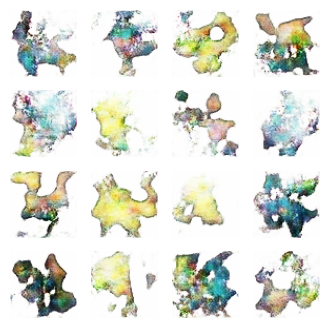

✅ Image saved at epoch 210
Epoch 210/2000 done ✅
Epoch 211/2000 done ✅
Epoch 212/2000 done ✅
Epoch 213/2000 done ✅
Epoch 214/2000 done ✅
Epoch 215/2000 done ✅
Epoch 216/2000 done ✅
Epoch 217/2000 done ✅
Epoch 218/2000 done ✅
Epoch 219/2000 done ✅


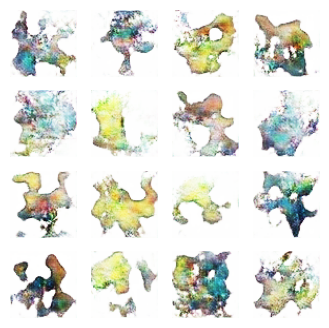

✅ Image saved at epoch 220
Epoch 220/2000 done ✅
Epoch 221/2000 done ✅
Epoch 222/2000 done ✅
Epoch 223/2000 done ✅
Epoch 224/2000 done ✅
Epoch 225/2000 done ✅
Epoch 226/2000 done ✅
Epoch 227/2000 done ✅
Epoch 228/2000 done ✅
Epoch 229/2000 done ✅


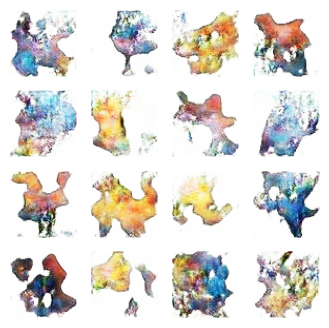

✅ Image saved at epoch 230
Epoch 230/2000 done ✅
Epoch 231/2000 done ✅
Epoch 232/2000 done ✅
Epoch 233/2000 done ✅
Epoch 234/2000 done ✅
Epoch 235/2000 done ✅
Epoch 236/2000 done ✅
Epoch 237/2000 done ✅
Epoch 238/2000 done ✅
Epoch 239/2000 done ✅


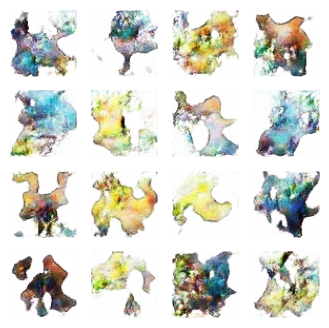

✅ Image saved at epoch 240
Epoch 240/2000 done ✅
Epoch 241/2000 done ✅
Epoch 242/2000 done ✅
Epoch 243/2000 done ✅
Epoch 244/2000 done ✅
Epoch 245/2000 done ✅
Epoch 246/2000 done ✅
Epoch 247/2000 done ✅
Epoch 248/2000 done ✅
Epoch 249/2000 done ✅


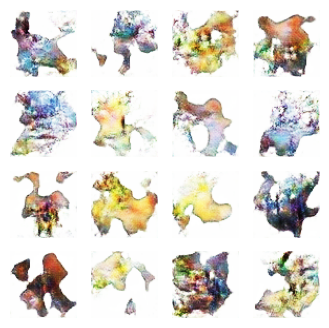

✅ Image saved at epoch 250
Epoch 250/2000 done ✅
Epoch 251/2000 done ✅
Epoch 252/2000 done ✅
Epoch 253/2000 done ✅
Epoch 254/2000 done ✅
Epoch 255/2000 done ✅
Epoch 256/2000 done ✅
Epoch 257/2000 done ✅
Epoch 258/2000 done ✅
Epoch 259/2000 done ✅


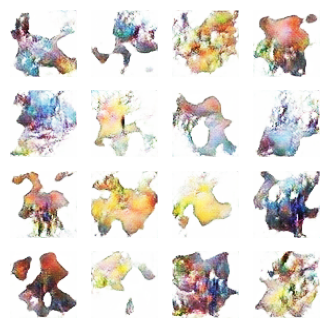

✅ Image saved at epoch 260
Epoch 260/2000 done ✅
Epoch 261/2000 done ✅
Epoch 262/2000 done ✅
Epoch 263/2000 done ✅
Epoch 264/2000 done ✅
Epoch 265/2000 done ✅
Epoch 266/2000 done ✅
Epoch 267/2000 done ✅
Epoch 268/2000 done ✅
Epoch 269/2000 done ✅


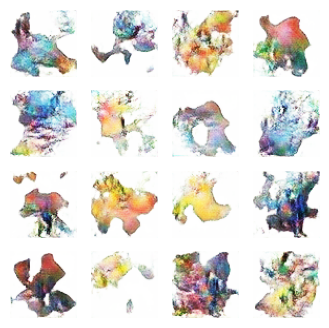

✅ Image saved at epoch 270
Epoch 270/2000 done ✅
Epoch 271/2000 done ✅
Epoch 272/2000 done ✅
Epoch 273/2000 done ✅
Epoch 274/2000 done ✅
Epoch 275/2000 done ✅
Epoch 276/2000 done ✅
Epoch 277/2000 done ✅
Epoch 278/2000 done ✅
Epoch 279/2000 done ✅


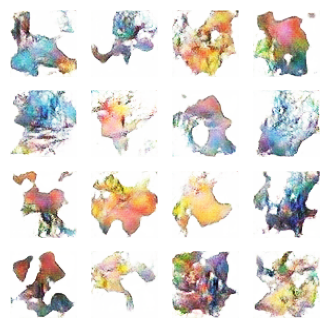

✅ Image saved at epoch 280
Epoch 280/2000 done ✅
Epoch 281/2000 done ✅
Epoch 282/2000 done ✅
Epoch 283/2000 done ✅
Epoch 284/2000 done ✅
Epoch 285/2000 done ✅
Epoch 286/2000 done ✅
Epoch 287/2000 done ✅
Epoch 288/2000 done ✅
Epoch 289/2000 done ✅


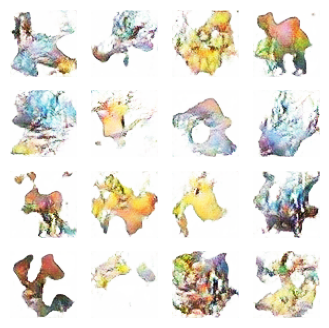

✅ Image saved at epoch 290
Epoch 290/2000 done ✅
Epoch 291/2000 done ✅
Epoch 292/2000 done ✅
Epoch 293/2000 done ✅
Epoch 294/2000 done ✅
Epoch 295/2000 done ✅
Epoch 296/2000 done ✅
Epoch 297/2000 done ✅
Epoch 298/2000 done ✅
Epoch 299/2000 done ✅


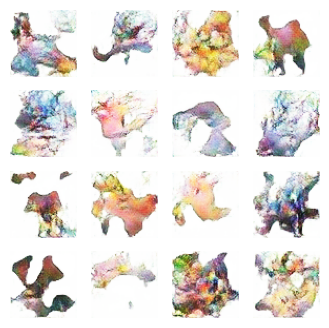

✅ Image saved at epoch 300
Epoch 300/2000 done ✅
Epoch 301/2000 done ✅
Epoch 302/2000 done ✅
Epoch 303/2000 done ✅
Epoch 304/2000 done ✅
Epoch 305/2000 done ✅
Epoch 306/2000 done ✅
Epoch 307/2000 done ✅
Epoch 308/2000 done ✅
Epoch 309/2000 done ✅


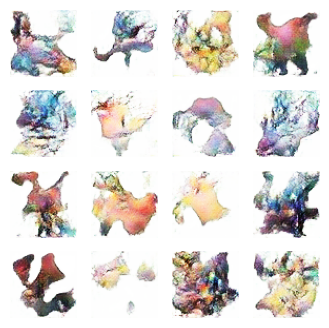

✅ Image saved at epoch 310
Epoch 310/2000 done ✅
Epoch 311/2000 done ✅
Epoch 312/2000 done ✅
Epoch 313/2000 done ✅
Epoch 314/2000 done ✅
Epoch 315/2000 done ✅
Epoch 316/2000 done ✅
Epoch 317/2000 done ✅
Epoch 318/2000 done ✅
Epoch 319/2000 done ✅


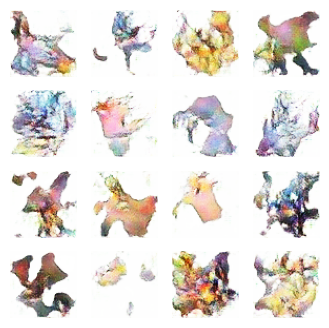

✅ Image saved at epoch 320
Epoch 320/2000 done ✅
Epoch 321/2000 done ✅
Epoch 322/2000 done ✅
Epoch 323/2000 done ✅
Epoch 324/2000 done ✅
Epoch 325/2000 done ✅
Epoch 326/2000 done ✅
Epoch 327/2000 done ✅
Epoch 328/2000 done ✅
Epoch 329/2000 done ✅


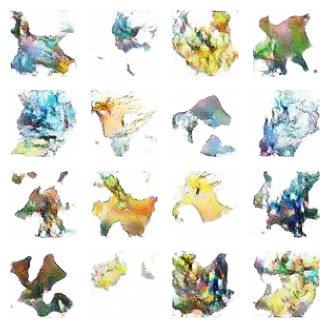

✅ Image saved at epoch 330
Epoch 330/2000 done ✅
Epoch 331/2000 done ✅
Epoch 332/2000 done ✅
Epoch 333/2000 done ✅
Epoch 334/2000 done ✅
Epoch 335/2000 done ✅
Epoch 336/2000 done ✅
Epoch 337/2000 done ✅
Epoch 338/2000 done ✅
Epoch 339/2000 done ✅


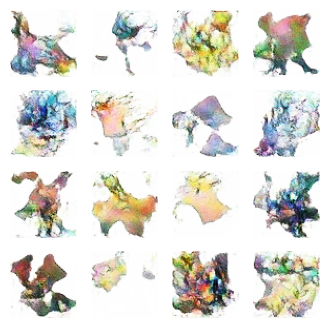

✅ Image saved at epoch 340
Epoch 340/2000 done ✅
Epoch 341/2000 done ✅
Epoch 342/2000 done ✅
Epoch 343/2000 done ✅
Epoch 344/2000 done ✅
Epoch 345/2000 done ✅
Epoch 346/2000 done ✅
Epoch 347/2000 done ✅
Epoch 348/2000 done ✅
Epoch 349/2000 done ✅


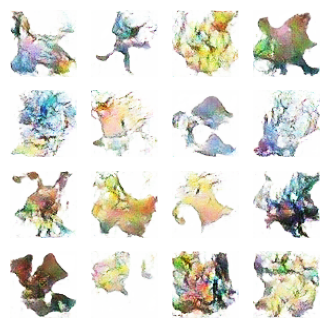

✅ Image saved at epoch 350
Epoch 350/2000 done ✅
Epoch 351/2000 done ✅
Epoch 352/2000 done ✅
Epoch 353/2000 done ✅
Epoch 354/2000 done ✅
Epoch 355/2000 done ✅
Epoch 356/2000 done ✅
Epoch 357/2000 done ✅
Epoch 358/2000 done ✅
Epoch 359/2000 done ✅


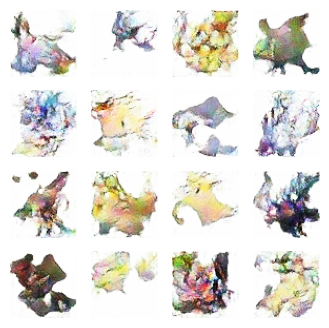

✅ Image saved at epoch 360
Epoch 360/2000 done ✅
Epoch 361/2000 done ✅
Epoch 362/2000 done ✅
Epoch 363/2000 done ✅
Epoch 364/2000 done ✅
Epoch 365/2000 done ✅
Epoch 366/2000 done ✅
Epoch 367/2000 done ✅
Epoch 368/2000 done ✅
Epoch 369/2000 done ✅


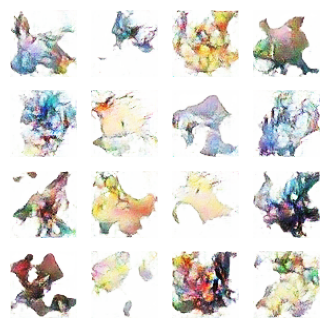

✅ Image saved at epoch 370
Epoch 370/2000 done ✅
Epoch 371/2000 done ✅
Epoch 372/2000 done ✅
Epoch 373/2000 done ✅
Epoch 374/2000 done ✅
Epoch 375/2000 done ✅
Epoch 376/2000 done ✅
Epoch 377/2000 done ✅
Epoch 378/2000 done ✅
Epoch 379/2000 done ✅


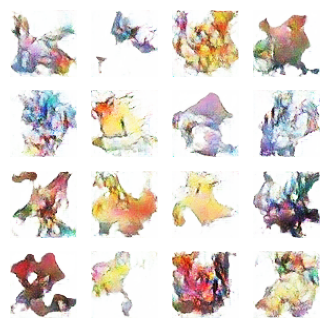

✅ Image saved at epoch 380
Epoch 380/2000 done ✅
Epoch 381/2000 done ✅
Epoch 382/2000 done ✅
Epoch 383/2000 done ✅
Epoch 384/2000 done ✅
Epoch 385/2000 done ✅
Epoch 386/2000 done ✅
Epoch 387/2000 done ✅
Epoch 388/2000 done ✅
Epoch 389/2000 done ✅


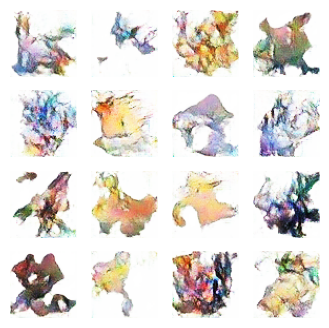

✅ Image saved at epoch 390
Epoch 390/2000 done ✅
Epoch 391/2000 done ✅
Epoch 392/2000 done ✅
Epoch 393/2000 done ✅
Epoch 394/2000 done ✅
Epoch 395/2000 done ✅
Epoch 396/2000 done ✅
Epoch 397/2000 done ✅
Epoch 398/2000 done ✅
Epoch 399/2000 done ✅


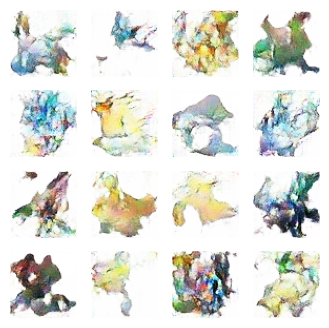

✅ Image saved at epoch 400
Epoch 400/2000 done ✅
Epoch 401/2000 done ✅
Epoch 402/2000 done ✅
Epoch 403/2000 done ✅
Epoch 404/2000 done ✅
Epoch 405/2000 done ✅
Epoch 406/2000 done ✅
Epoch 407/2000 done ✅
Epoch 408/2000 done ✅
Epoch 409/2000 done ✅


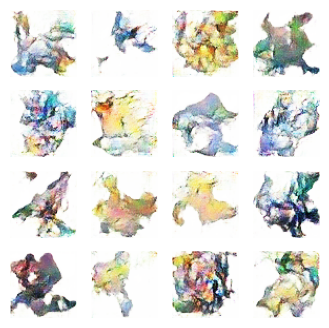

✅ Image saved at epoch 410
Epoch 410/2000 done ✅
Epoch 411/2000 done ✅
Epoch 412/2000 done ✅
Epoch 413/2000 done ✅
Epoch 414/2000 done ✅
Epoch 415/2000 done ✅
Epoch 416/2000 done ✅
Epoch 417/2000 done ✅
Epoch 418/2000 done ✅
Epoch 419/2000 done ✅


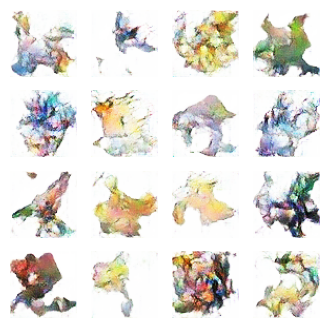

✅ Image saved at epoch 420
Epoch 420/2000 done ✅


In [ ]:
# 6. 実行 (2,000エポック)
train(train_dataset, 2000)

In [ ]:
# 7. GIF作成 (最後に1回だけ)

# GIF作成
anim_file = 'pokemon_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = sorted(glob.glob('pokemon_image_at_epoch_*.png'))
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filenames[-1])
    writer.append_data(image)

print(f'GIF saved to {anim_file}')

# Notebookに表示
display(IPyImage(filename=anim_file))